# Generalized Lasso Problem

## 1-D Case (Total Variation Denoising and Trend Filtering)

The first part of the project covers the simple 1-D case of the fused lasso, also called the total variation denoising in 1D.

### Primal Subgradient Method

In [1]:
import numpy as np
import numpy.random as rn
import numpy.linalg as la
import matplotlib.pyplot as plt

In [2]:
# Generate 1D data
def data(size):
    y = np.zeros((size,1))
    y[0:size/5] = 20*rn.random((size/5,1)) + 50
    y[size/5:3*size/5] = 15*rn.random((2*size/5,1)) + 30
    y[3*size/5:4*size/5] = 20*rn.random((size/5,1)) + 60
    y[4*size/5:size] = 10*rn.random((size/5,1)) + 90
    return y

# Penalty Matrix for TV Denoising
def denoisingMat(size):
    add = np.concatenate((np.zeros((size-1,1)),np.eye(size-1)), axis = 1)
    sub = np.concatenate((-np.eye(size-1),np.zeros((size-1,1))), axis = 1)
    D = add + sub
    return D

def trendFilteringLinearMat(size):
    add1 = np.concatenate((np.zeros((size-2,2)),np.eye(size-2)), axis = 1)
    sub = np.concatenate((np.zeros((size-2,1)),np.concatenate((-2*np.eye(size-2),np.zeros((size-2,1))), axis = 1)), axis = 1)
    add2 = np.concatenate((np.eye(size-2),np.zeros((size-2,2))), axis = 1)
    D = add1 + sub + add2
    return D

In [166]:
def costFunc(y, beta, D, lam):
    fVal = 0.5*la.norm(y - beta)**2 + lam*la.norm(np.dot(D,beta),ord = 1)
    return fVal

def subgradient(y, beta, D, t, lam, c=1e-1):
    delF1 = beta - y
    delF2 = np.dot(D.T,np.sign(np.dot(D,beta)))*lam
    delF = delF1 + delF2
    beta = beta - c/(np.sqrt(t+1))*(delF)
    return beta

size = 300
y = data(size)

def descent(update, y, reg, T=int(5e3)):
    size = y.shape[0]
    D = denoisingMat(size)
#     D = trendFilteringLinearMat(size)
    beta = np.zeros((size,1))
    error = []
    l1 = []
    for t in xrange(T):
        beta = update(y, beta, D, t, reg)
        # record error and l1 norm
        if (t % 10 == 0) or (t == T - 1):
            error.append(la.norm(beta - y))
            l1.append(np.sum(np.abs(np.dot(D,beta))))
            print t
            assert not np.isnan(error[-1])

    return beta, error, l1

In [167]:
beta_sg10, error_sg10, l1_sg10 = descent(subgradient, y, reg=10)
beta_sg5, error_sg5, l1_sg5 = descent(subgradient, y, reg=5)
beta_sg20, error_sg20, l1_sg20 = descent(subgradient, y, reg=20)


0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2190
2200
2210
2

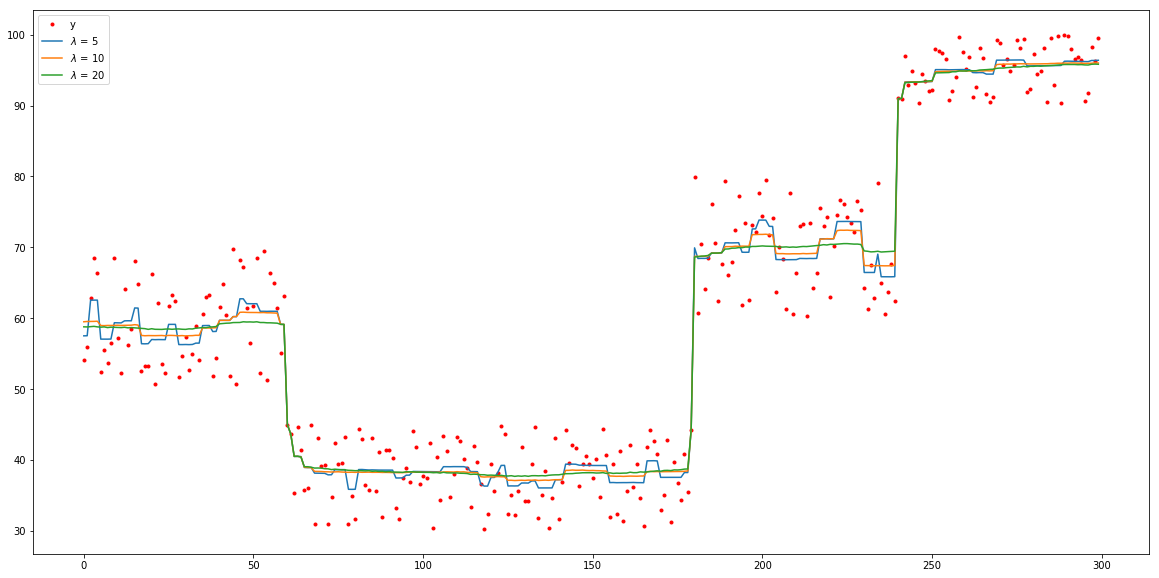

In [168]:
plt.clf()
plt.figure(figsize=(20,10))
plt.plot(y, 'r.',label='y')
plt.plot(beta_sg5,label='$\lambda$ = 5')
plt.plot(beta_sg10,label='$\lambda$ = 10')
plt.plot(beta_sg20,label='$\lambda$ = 20')
plt.title('')
plt.legend()
plt.show()

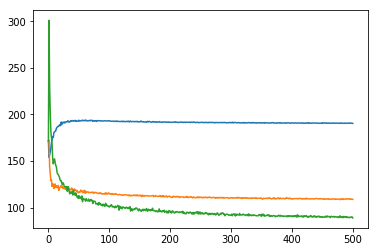

In [169]:
plt.plot(l1_sg5)
plt.plot(l1_sg10)
plt.plot(l1_sg20)
plt.show()

### Dual Proximal Gradient Method

In [212]:
def costFuncDualProx(y, v):
    fVal = 0.5*(np.dot(y.T,y) - np.dot((y+v).T,(y+v)))
    return fVal

def gradientDualProx(y, u, D, lam, c=1e-1):
    delFStar = -np.dot(D,(y - np.dot(D.T,u)))
    u = u - c*(delFStar)
    u[u > lam] = lam
    u[u < -lam] = -lam
    return u

def descentDualProx(update, y, reg, T=int(5e3)):
    size = y.shape[0]
    D = denoisingMat(size)
#     D = trendFilteringLinearMat(size)
    beta = np.zeros((size,1))
    u = np.zeros((D.shape[0],1))
    
    error = []
    l1 = []
    for t in xrange(T):
        u = update(y, u, D, reg)
        # record error and l1 norm
        if (t % 10 == 0) or (t == T - 1):
            beta = y - np.dot(D.T,u)
#             error.append(la.norm(beta - y))
            error.append(costFuncDualProx(y, -np.dot(D.T,u)))
            l1.append(np.sum(np.abs(np.dot(D,beta))))
            print t
            assert not np.isnan(error[-1])
    
    return beta, error, l1

In [213]:
beta_dpg5, error_dpg5, l1_dpg5 = descentDualProx(gradientDualProx, y, reg=5)
beta_dpg10, error_dpg10, l1_dpg10 = descentDualProx(gradientDualProx, y, reg=10)
beta_dpg20, error_dpg20, l1_dpg20 = descentDualProx(gradientDualProx, y, reg=20)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2190
2200
2210
2

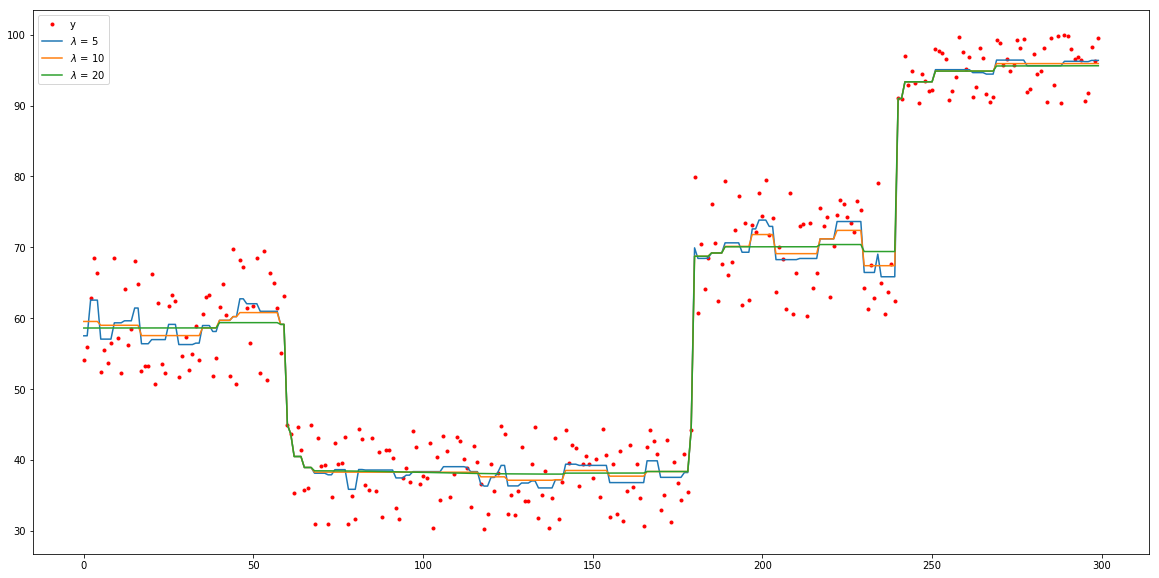

In [214]:
plt.clf()
plt.figure(figsize=(20,10))
plt.plot(y, 'r.',label='y')
# plt.plot(beta_dpg0,label='$\lambda$ = 0')
plt.plot(beta_dpg5,label='$\lambda$ = 5')
plt.plot(beta_dpg10,label='$\lambda$ = 10')
plt.plot(beta_dpg20,label='$\lambda$ = 20')
plt.title('')
plt.legend()
plt.show()

In [203]:
beta_dpg0, error_dpg0, l1_dpg0 = descentDualProx(gradientDualProx, y, reg=0)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2190
2200
2210
2

In [208]:
l1_dpg5

[1227.8981984098016,
 306.58278761408917,
 239.09927375116078,
 218.25523052743029,
 208.24445887306484,
 203.00901825113704,
 199.74592433088435,
 197.48454623358461,
 195.82303770749741,
 194.50580597508633,
 193.50421512670226,
 192.77701133599317,
 192.18595281467421,
 191.68864034837429,
 191.26454669400022,
 190.89935834623276,
 190.58629002648115,
 190.33125174344116,
 190.11646970066627,
 189.92923884870049,
 189.76314354806317,
 189.61450135696535,
 189.48084325806164,
 189.36034387763553,
 189.25778547152092,
 189.16764879219684,
 189.08623144746335,
 189.01245719332326,
 188.94548931677772,
 188.88457079372057,
 188.82903292115367,
 188.77829434971193,
 188.7319921931952,
 188.69804335953467,
 188.67378359422224,
 188.65474059214617,
 188.63904677642711,
 188.62568444160536,
 188.6140497045786,
 188.60376546068113,
 188.59458370284636,
 188.58633188536891,
 188.57888297410867,
 188.57213850266089,
 188.56601882496892,
 188.56045737676013,
 188.55539719022258,
 188.5507886914

### Fast Dual Path Algorithm

## Graph (Total Variation Denoising)

### Primal Subgradient Method

In [189]:
# Load image

from PIL import Image
import matplotlib.image as mpimg

# orig_img = Image.open('data/randompic.png').convert('L')
# orig_img.save('data/randompic_greyscale.png')
# corr_img = Image.open('data/randompic_corrupted.png').convert('L')
# corr_img.save('data/randompic_greyscale_corrupted.png')

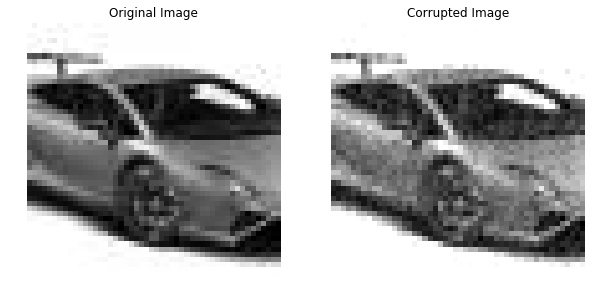

In [190]:
def loadImage():
    # Convert to arrays.
    orig_img = Image.open("data/randompic_greyscale.png")
    # corr_img = Image.open("data/camus_greyscale_corrupted.png")
    # orig_img = mpimg.imread("data/randompic_greyscale.png")
    # corr_img = mpimg.imread("data/randompic_greyscale_corrupted.png")

    np.random.seed(1)
    p = 0.05

    Uorig = np.array(orig_img)
    row, col = Uorig.shape

    Known = np.ones((row, col))
    for i in xrange(row):
        for j in xrange(col):
            if np.random.random() > (1-p):
                Known[i, j] = 0
    
#     size1 = Known[Known == 0].shape
#     Known[Known == 0] = 0.05*rn.random((size1,)) + 0.5
#     print Known
#     Ucorr = Known*Uorig
    Ucorr = Uorig + 40*rn.random((row, col))
    Ucorr[Ucorr > 255] = 255
    Ucorr[Ucorr < 0] = 0
    corr_img = Image.fromarray(np.uint8(Ucorr))
    corr_img.save('data/randompic_greyscale_corrupted.png')
    return Ucorr, corr_img, orig_img

Ucorr, corr_img, orig_img = loadImage()

%matplotlib inline
fig, ax = plt.subplots(1, 2,figsize=(10, 5))
print ax
ax[0].imshow(np.asarray(orig_img),cmap='gray');
ax[0].set_title("Original Image")
ax[0].axis('off')
ax[1].imshow(np.asarray(corr_img),cmap='gray');
ax[1].set_title("Corrupted Image")
ax[1].axis('off');

In [191]:
def denoisingMat2DGrid(size):
    add = np.eye(size)
    sub = -np.eye(size)
    D = np.concatenate((add,sub),axis = 1)
    return D

def denoisingMatGraph(row, col):
    D1 = np.zeros(((row)*(col-1),row*col))
    D2 = np.zeros(((row-1)*(col),row*col))
    DSegmentRow = denoisingMat(col)
    DSegmentCol = denoisingMat2DGrid(col)
    for i in range(row):
        startRow = i*(col-1)
        endRow = (i+1)*(col-1)
        startCol = i*(col)
        endCol = (i+1)*(col)
        D1[startRow:endRow,startCol:endCol] = DSegmentRow
    for i in range(row-1):
        startRow = i*(col)
        endRow = (i+1)*(col)
        startCol = i*(col)
        endCol = (i+2)*(col)
        D2[startRow:endRow,startCol:endCol] = DSegmentCol
    D = np.concatenate((D1, D2), axis = 0)
    return D

In [192]:
def descentGraph(update, Ucorr, reg, T=int(2e3)):
    row, col = Ucorr.shape
    y = np.reshape(Ucorr, (-1, 1))
    D = denoisingMatGraph(row, col)
    beta = np.zeros((y.shape[0],1))
    error = []
    l1 = []
    for t in xrange(T):
        beta = update(y, beta, D, t, reg)
        # record error and l1 norm
        if (t % 100 == 0) or (t == T - 1):
            error.append(la.norm(beta - y))
            l1.append(np.sum(np.abs(np.dot(D,beta))))
            print t
            assert not np.isnan(error[-1])
    
    beta = np.reshape(beta, (row, col))
    return Ucorr, beta, error, l1

In [193]:
Ucorr, beta_sg_graph, error_sg_graph, l1_sg_graph = descentGraph(subgradient, Ucorr, reg=10)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
1999


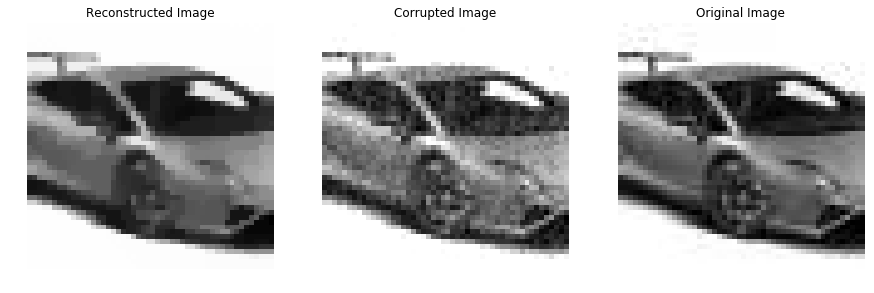

In [194]:
reconstruct_img = Image.fromarray(np.uint8(beta_sg_graph))

%matplotlib inline
fig, ax = plt.subplots(1, 3,figsize=(15, 10))
print ax
ax[0].imshow(np.asarray(reconstruct_img),cmap='gray');
ax[0].set_title("Reconstructed Image")
ax[0].axis('off')
ax[1].imshow(np.asarray(corr_img),cmap='gray');
ax[1].set_title("Corrupted Image")
ax[1].axis('off');
ax[2].imshow(np.asarray(orig_img),cmap='gray');
ax[2].set_title("Original Image")
ax[2].axis('off');

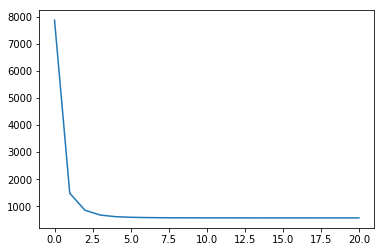

In [196]:
plt.plot(error_sg_graph)

### Dual Proximal Gradient Method

In [199]:
def descentDualProxGraph(update, Ucorr, reg, T=int(1e3)):
    row, col = Ucorr.shape
    y = np.reshape(Ucorr, (-1, 1))
    D = denoisingMatGraph(row, col)
#     D = trendFilteringLinearMat(size)
    beta = np.zeros((size,1))
    u = np.zeros((D.shape[0],1))
    
    error = []
    l1 = []
    for t in xrange(T):
        u = update(y, u, D, reg)
        # record error and l1 norm
        if (t % 100 == 0) or (t == T - 1):
            beta = y - np.dot(D.T,u)
#             print beta
#             print u
#             error.append(la.norm(beta - y))
            error.append(costFuncDualProx(y, -np.dot(D.T,u)))
            l1.append(np.sum(np.abs(np.dot(D,beta))))
            print t
            assert not np.isnan(error[-1])
    
    beta = np.reshape(beta, (row, col))
    return beta, error, l1

In [200]:
beta_dpg_graph, error_dpg_graph, l1_dpg_graph = descentDualProxGraph(gradientDualProx, Ucorr, reg=10)

0
100
200
300
400
500
600
700
800
900
999


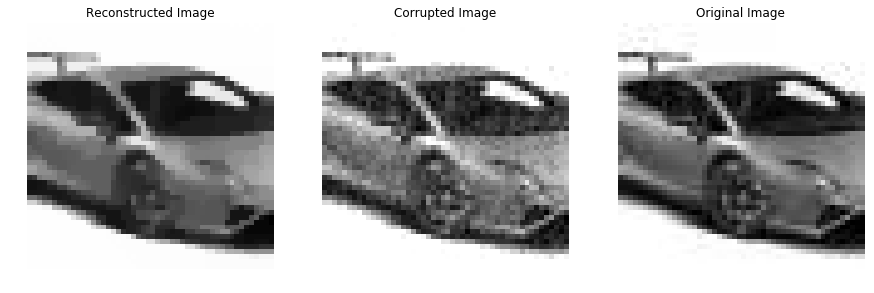

In [201]:
reconstruct_img_dpg = Image.fromarray(np.uint8(beta_sg_graph))

%matplotlib inline
fig, ax = plt.subplots(1, 3,figsize=(15, 10))
print ax
ax[0].imshow(np.asarray(reconstruct_img_dpg),cmap='gray');
ax[0].set_title("Reconstructed Image")
ax[0].axis('off')
ax[1].imshow(np.asarray(corr_img),cmap='gray');
ax[1].set_title("Corrupted Image")
ax[1].axis('off');
ax[2].imshow(np.asarray(orig_img),cmap='gray');
ax[2].set_title("Original Image")
ax[2].axis('off');

### Fast Dual Path Algorithm